In [1]:
import anndata
import time, os, sys
from datetime import datetime

import pandas as pd
import glob
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np

#import skimage.io as io
import scimap as sm
import scanpy as sc

Running SCIMAP  2.1.3


/Users/chiaraschiller/miniconda3/envs/scimap_delaunay/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [8]:
#import simualted data

# Load in dataset. This is a .csv file with all samples concatenated together
path_to_csv = './../../../../data/20250217_asym01_nbh2_1000dim_grid200_300iter_50swaps'


# read in all csv files (they all have ct, x and y coordinates) give them a new sample id column of their file names and row bind them all to one big dataframe
# Use glob to get all the CSV files in the folder
csv_files = glob.glob(os.path.join(path_to_csv, '*.csv'))

# Initialize an empty list to store individual DataFrames
data_frames = []

# Loop through the CSV files and process each one
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)

    # Extract the file name without the extension and path
    sample_id = os.path.splitext(os.path.basename(file))[0]

    # Add a new column for the sample ID
    df['sample_id'] = sample_id

    # Append the DataFrame to the list
    data_frames.append(df)

# Concatenate all DataFrames into one big DataFrame
obs = pd.concat(data_frames, ignore_index=True)


In [3]:
# for image, show the counts of unique ct
print(obs['ct'].value_counts())

ct
1.00    1082267
0.00    1073027
2.00    1065261
3.00    1062677
Name: count, dtype: int64


In [9]:
# add marker files to it, as SpatialLDA needs them
obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Load dataframe into anndata object
# dataframe for annotating the observations
obs = obs.astype({'ct':'string'})

# the data matrix 
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs

adata.obs

,x,y,ct,sample_id,D,E
0,0.00,0.00,3.0,cross01_0.45_ab0_0.15_44,58,59
1,26.09,0.00,0.0,cross01_0.45_ab0_0.15_44,74,35
2,50.18,0.00,3.0,cross01_0.45_ab0_0.15_44,26,97
3,77.28,0.00,3.0,cross01_0.45_ab0_0.15_44,73,2
4,101.85,0.00,2.0,cross01_0.45_ab0_0.15_44,85,97
...,...,...,...,...,...,...
4283227,961.25,784.66,0.0,cross01_0.45_ab0_0.1_17,64,9
4283228,348.72,306.53,2.0,cross01_0.45_ab0_0.1_17,17,46
4283229,392.80,313.55,1.0,cross01_0.45_ab0_0.1_17,2,21
4283230,474.07,92.53,1.0,cross01_0.45_ab0_0.1_17,3,72


In [10]:
# run spatial interaction to look at interaction of phenotypes without motifs
sm.tl.spatial_interaction(adata, 
                          phenotype='ct', 
                          x_coordinate='x', y_coordinate='y', 
                          imageid='sample_id', 
                          #knn=8, 
                          permutation = 300,
                          method='delaunay',
                          verbose=True,
                          #normalization = 'conditional',
                          pval_method = 'zscore',
                          label='delauany_zscore_scimap')

Processing Image: ['cross01_0.45_ab0_0.15_44']
Performing Delaunay triangulation to identify neighbours for every cell
[[   1 1190 1544 ...   -1   -1   -1]
 [   0    2  198 ...   -1   -1   -1]
 [   1    3 1420 ...   -1   -1   -1]
 ...
 [ 131  591 1520 ...   -1   -1   -1]
 [ 366 1495 1402 ...   -1   -1   -1]
 [ 512 1386  235 ...   -1   -1   -1]]
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['cross01_0.6_ab0_0.55_24']
Performing Delaunay triangulation to identify neighbours for every cell
[[   1  452 1478 ...   -1   -1   -1]
 [   0    2  895 ...   -1   -1   -1]
 [   1    3  167 ...   -1   -1   -1]
 ...
 [1376  834 1039 ...   -1   -1   -1]
 [1025  453 1138 ...   -1   -1   -1]
 [ 710 1009 1267 ...   -1   -1   -1]]
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['ran_ab0_0.05_5']
Performing Delaunay triangulation to identify neighbours for every cell
[[11

AnnData object with n_obs × n_vars = 4283232 × 2
    obs: 'x', 'y', 'ct', 'sample_id', 'D', 'E'
    uns: 'delauany_zscore_scimap'

In [11]:
save_df = adata.uns['delauany_zscore_scimap']
# Convert 'phenotype' and 'neighbour_phenotype' columns to string types
save_df['phenotype'] = save_df['phenotype'].astype(str)
save_df['neighbour_phenotype'] = save_df['neighbour_phenotype'].astype(str)

# Combine 'phenotype' and 'neighbour_phenotype' into 'new_column'
save_df['new_column'] = save_df['phenotype'] + "_" + save_df['neighbour_phenotype']

# Drop the 'phenotype' and 'neighbour_phenotype' columns
save_df = save_df.drop(columns=['phenotype', 'neighbour_phenotype'])

# Set 'new_column' as the index (row names)
save_df = save_df.set_index('new_column')

# Transpose the dataframe
save_df_transposed = save_df.transpose()
# Remove '.0' from column names
save_df_transposed.columns = save_df_transposed.columns.str.replace(r"\.0",
                                                                    "",
                                                                    regex=True)
save_df_transposed = save_df_transposed[~save_df_transposed.index.str.contains('pvalue')]
save_df_transposed = save_df_transposed[~save_df_transposed.index.str.contains('count')]
save_df_transposed.index = save_df_transposed.index.str.replace(r"zscore_", "", regex=True)


# View the transposed dataframe (optional)
save_df_transposed
# save the dataframe as csv
save_df_transposed.to_csv('./../../../Comparison/20250218_results_asym/scimap_delaunay_4ct_cross01.csv', index=True)

In [12]:
df = pd.DataFrame(save_df_transposed)
#df.set_index("new_column", inplace=True)  # Set first column as index
df


new_column,0_0,0_1,0_2,0_3,1_0,1_1,1_2,1_3,2_0,2_1,2_2,2_3,3_0,3_1,3_2,3_3
cross01_0.45_ab0_0.15_44,-0.84,0.90,1.00,-0.89,0.95,-0.88,-1.00,-0.95,0.88,-0.83,-0.98,1.00,-0.78,-0.79,1.00,0.89
cross01_0.6_ab0_0.55_24,-0.64,1.00,0.55,0.53,0.75,1.00,-0.47,-0.44,0.88,-1.00,0.74,0.70,0.91,-1.00,0.74,0.80
ran_ab0_0.05_5,0.81,-0.90,1.00,-0.93,-0.81,0.94,-1.00,1.00,0.81,-0.90,-0.89,1.00,-0.75,0.91,1.00,-0.93
cross01_0.45_ab0_0.15_50,-0.96,1.00,-0.97,-0.97,1.00,0.97,-0.93,-0.90,-0.94,-0.90,1.00,0.98,-0.90,-0.83,0.93,1.00
cross01_0.6_ab0_0.55_30,-0.60,1.00,0.53,-0.51,0.72,1.00,-0.45,-0.48,0.85,-1.00,0.76,0.79,-0.77,-1.00,0.74,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cross01_0.45_ab0_0.15_49,-0.82,1.00,-0.94,0.93,1.00,0.93,-0.85,-0.88,-0.88,-0.80,1.00,0.91,0.95,-0.91,1.00,-0.93
cross01_0.6_ab0_0.55_29,-0.68,1.00,0.59,0.54,0.67,1.00,-0.47,-0.44,0.84,-1.00,0.74,0.70,0.82,-1.00,0.75,0.65
ran_ab0_0.05_8,-0.66,0.93,-0.89,1.00,0.80,-0.89,1.00,-0.97,-0.77,1.00,-0.89,-0.97,0.86,-0.97,-0.97,-1.00
ran_ab0_0.45_44,1.00,0.92,-0.98,-0.91,-0.97,-0.83,1.00,0.98,-0.97,0.94,1.00,-0.91,-0.99,1.00,-0.99,-0.89


TypeError: Image data of dtype object cannot be converted to float

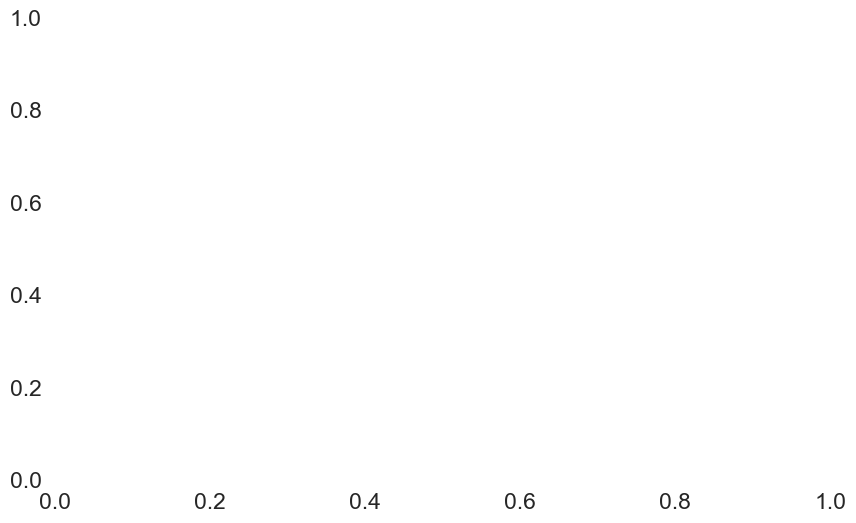

In [17]:
# make heatmap of save_df_transposed
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(save_df_transposed)
#df.set_index("new_column", inplace=True)  # Set first column as index

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap="coolwarm", annot=True, fmt=".2f")  # Change cmap for color scheme

plt.title("Heatmap of Dataframe")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.xticks(rotation=45)  # Rotate column labels for better readability
plt.yticks(rotation=0)  # Keep row labels readable
plt.show()



In [19]:
save_df_transposed.to_csv('./../../../SCNA_thesis/github/Comparison/results_4ct_asym/scimap_classic_delaunay_4ct_cross01.csv', index=True)

In [9]:
save_df

,zscore_cross01_0.45_ab0_0.15_44,pvalue_cross01_0.45_ab0_0.15_44,count_cross01_0.45_ab0_0.15_44,zscore_cross01_0.6_ab0_0.55_24,pvalue_cross01_0.6_ab0_0.55_24,count_cross01_0.6_ab0_0.55_24,zscore_ran_ab0_0.05_5,pvalue_ran_ab0_0.05_5,count_ran_ab0_0.05_5,zscore_cross01_0.45_ab0_0.15_50,...,count_cross01_0.6_ab0_0.55_29,zscore_ran_ab0_0.05_8,pvalue_ran_ab0_0.05_8,count_ran_ab0_0.05_8,zscore_ran_ab0_0.45_44,pvalue_ran_ab0_0.45_44,count_ran_ab0_0.45_44,zscore_cross01_0.45_ab0_0.1_17,pvalue_cross01_0.45_ab0_0.1_17,count_cross01_0.45_ab0_0.1_17
new_column,,,,,,,,,,,,,,,,,,,,,
0.0_0.0,0.39,0.70,1.78,-3.53,0.00,1.74,2.33,0.02,1.79,-0.70,...,1.78,-2.62,0.01,1.54,0.81,0.42,1.89,-1.09,0.28,1.65
0.0_1.0,2.04,0.04,1.84,4.03,0.00,2.43,-0.42,0.68,1.78,0.41,...,2.36,-0.02,0.98,1.86,-0.65,0.52,1.76,1.08,0.28,1.78
0.0_2.0,0.41,0.68,1.93,0.58,0.56,1.66,0.73,0.47,1.90,0.33,...,1.74,0.14,0.89,1.86,0.40,0.69,1.88,-1.31,0.19,1.88
0.0_3.0,-1.58,0.11,1.77,2.00,0.05,1.70,-1.43,0.15,1.79,-0.29,...,1.65,1.80,0.07,1.99,-0.58,0.57,1.77,-0.11,0.91,1.99
1.0_0.0,1.93,0.05,1.85,-0.63,0.53,1.84,0.90,0.37,1.74,1.06,...,1.77,0.64,0.52,1.71,-1.16,0.25,1.80,1.53,0.13,1.74
1.0_1.0,-0.55,0.59,1.72,4.46,0.00,2.36,0.58,0.56,1.86,2.13,...,2.49,-0.81,0.42,1.83,-2.77,0.01,1.66,-1.47,0.14,1.64
1.0_2.0,-0.68,0.50,1.89,-2.50,0.01,1.53,-0.25,0.80,1.88,0.01,...,1.57,1.92,0.05,1.95,-0.89,0.37,1.82,0.72,0.47,1.95
1.0_3.0,-0.44,0.66,1.82,-1.94,0.05,1.53,0.49,0.62,1.91,-1.64,...,1.52,-0.00,1.00,1.91,2.07,0.04,1.87,-0.30,0.76,1.95
2.0_0.0,-0.76,0.45,1.74,-0.38,0.71,1.87,1.30,0.20,1.75,-1.02,...,1.76,-1.07,0.28,1.62,-0.62,0.54,1.83,-1.32,0.19,1.62
